# Dataset
* Satellite- GeoEye-1
* Ground sampling distance- 0.46m PAN 1.84m MS
* The number of bands for MS image- 4
* The radiometric resolution in bits- 11
* Location- London, UK

# Import Packages

In [1]:
import numpy as np
import cv2
import os
import scipy.io as sio
from scipy import ndimage
from scipy import signal
import scipy.misc as misc
from PIL import Image
from IPython.display import display, HTML

# Utils

In [2]:
def upsample_interp23(image, ratio):

    image = np.transpose(image, (2, 0, 1))
    
    b,r,c = image.shape

    CDF23 = 2*np.array([0.5, 0.305334091185, 0, -0.072698593239, 0, 0.021809577942, 0, -0.005192756653, 0, 0.000807762146, 0, -0.000060081482])
    d = CDF23[::-1] 
    CDF23 = np.insert(CDF23, 0, d[:-1])
    BaseCoeff = CDF23
    
    first = 1
    for z in range(1,int(np.log2(ratio))+1):
        I1LRU = np.zeros((b, 2**z*r, 2**z*c))
        if first:
            I1LRU[:, 1:I1LRU.shape[1]:2, 1:I1LRU.shape[2]:2]=image
            first = 0
        else:
            I1LRU[:,0:I1LRU.shape[1]:2,0:I1LRU.shape[2]:2]=image
        
        for ii in range(0,b):
            t = I1LRU[ii,:,:]
            for j in range(0,t.shape[0]):
                t[j,:]=ndimage.correlate(t[j,:],BaseCoeff,mode='wrap')
            for k in range(0,t.shape[1]):
                t[:,k]=ndimage.correlate(t[:,k],BaseCoeff,mode='wrap')
            I1LRU[ii,:,:]=t
        image = I1LRU
        
    re_image=np.transpose(I1LRU, (1, 2, 0))
        
    return re_image

# PCA (Principal Component Analysis)

In [3]:
import numpy as np
#from utils import upsample_interp23
from sklearn.decomposition import PCA as princomp

def PCA(pan, hs):

    M, N, c = pan.shape
    m, n, C = hs.shape
    
    ratio = int(np.round(M/m))
        
    print('get sharpening ratio: ', ratio)
    assert int(np.round(M/m)) == int(np.round(N/n))
    
    image_hr = pan
    
    #upsample
    u_hs = upsample_interp23(hs, ratio)
    
    p = princomp(n_components=C)
    pca_hs = p.fit_transform(np.reshape(u_hs, (M*N, C)))
    
    pca_hs = np.reshape(pca_hs, (M, N, C))
    
    I = pca_hs[:, :, 0]
    
    image_hr = (image_hr - np.mean(image_hr))*np.std(I, ddof=1)/np.std(image_hr, ddof=1)+np.mean(I)
    
    pca_hs[:, :, 0] = image_hr[:, :, 0]
    
    I_PCA = p.inverse_transform(pca_hs)
    
    #equalization
    I_PCA = I_PCA-np.mean(I_PCA, axis=(0, 1))+np.mean(u_hs)
    
    #adjustment
    I_PCA[I_PCA<0]=0
    I_PCA[I_PCA>1]=1
    
    return np.uint8(I_PCA*255)

# Load Data

(2048, 2048, 1) (512, 512, 4)


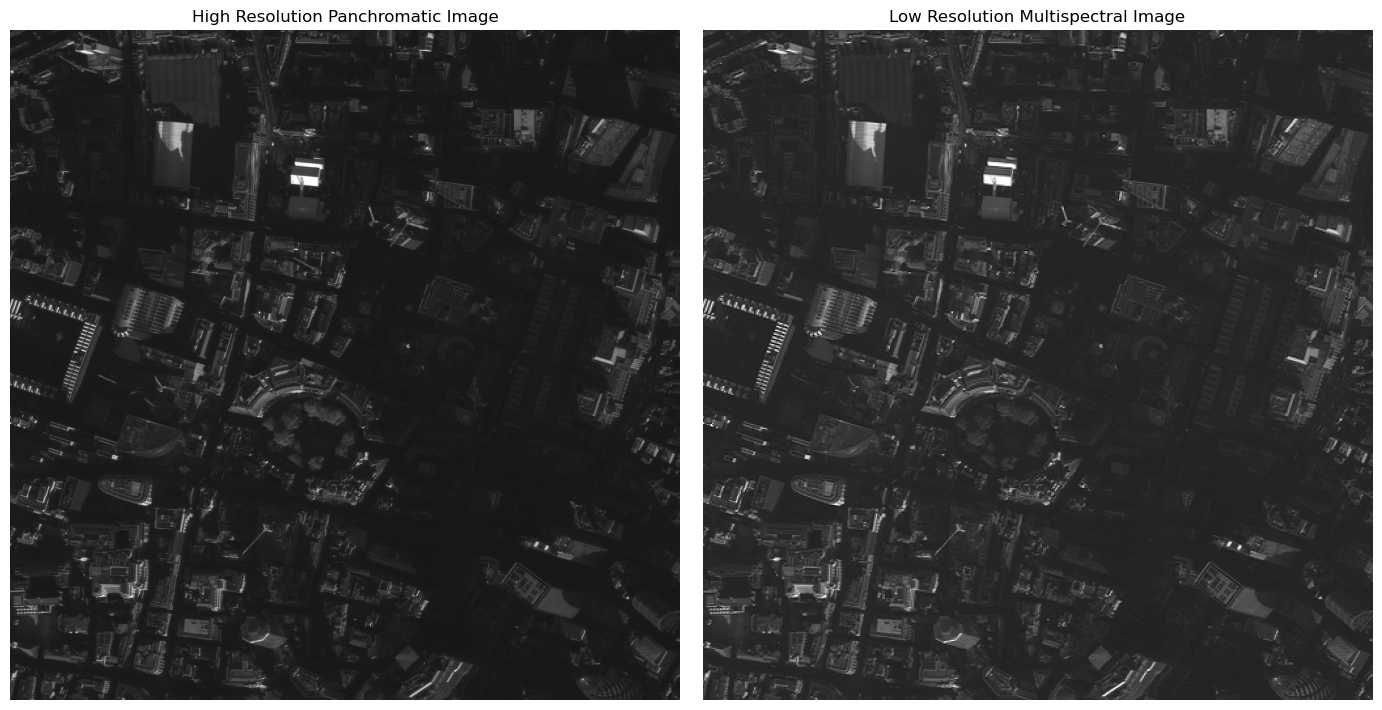

In [4]:
import imageio.v2 as imageio
import matplotlib.pyplot as plt

# Specify the path to your TIFF file
ms_tiff_path = 'PAirMax/GE_Lond_Urb/FR/MS_LR.tif'
pan_tiff_path = 'PAirMax/GE_Lond_Urb/FR/PAN.tif'

# Read the TIFF image
ms = imageio.imread(ms_tiff_path)
pan = imageio.imread(pan_tiff_path)

pan = np.expand_dims(pan, -1)
# ms= np.transpose(ms, (0, 1, 2))

print(pan.shape,ms.shape)

# Set the figure size
fig, axes = plt.subplots(1, 2, figsize=(14, 7))  # Adjust the figsize as needed

# Display the first image
axes[0].imshow(pan[:, :], cmap='gray')  # Assuming the image is grayscale
axes[0].set_title('High Resolution Panchromatic Image')
axes[0].axis('off')

# Display the second image
axes[1].imshow(ms[:, :, 1], cmap='gray')  # Assuming the image is grayscale
axes[1].set_title('Low Resolution Multispectral Image')
axes[1].axis('off')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()



# preprocess
# pan = np.expand_dims(pan, -1)
# ms= np.transpose(ms, (1, 2, 0))

max_patch, min_patch = np.max(ms, axis=(0,1)), np.min(ms, axis=(0,1))
ms = np.float32(ms-min_patch) / (max_patch - min_patch)
max_patch, min_patch = np.max(pan, axis=(0,1)), np.min(pan, axis=(0,1))
pan = np.float32(pan-min_patch) / (max_patch - min_patch)

# Apply PCA Algorithm

In [5]:
fused_img = PCA(pan[:, :, :], ms[:, :, :])
print(pan.shape,ms.shape,fused_img.shape)

save_dir='./results/'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
cv2.imwrite(save_dir+'PCA.tiff', fused_img[:, :, [0,1,3]])

get sharpening ratio:  4
(2048, 2048, 1) (512, 512, 4) (2048, 2048, 4)


True

# Printing Resulting Image

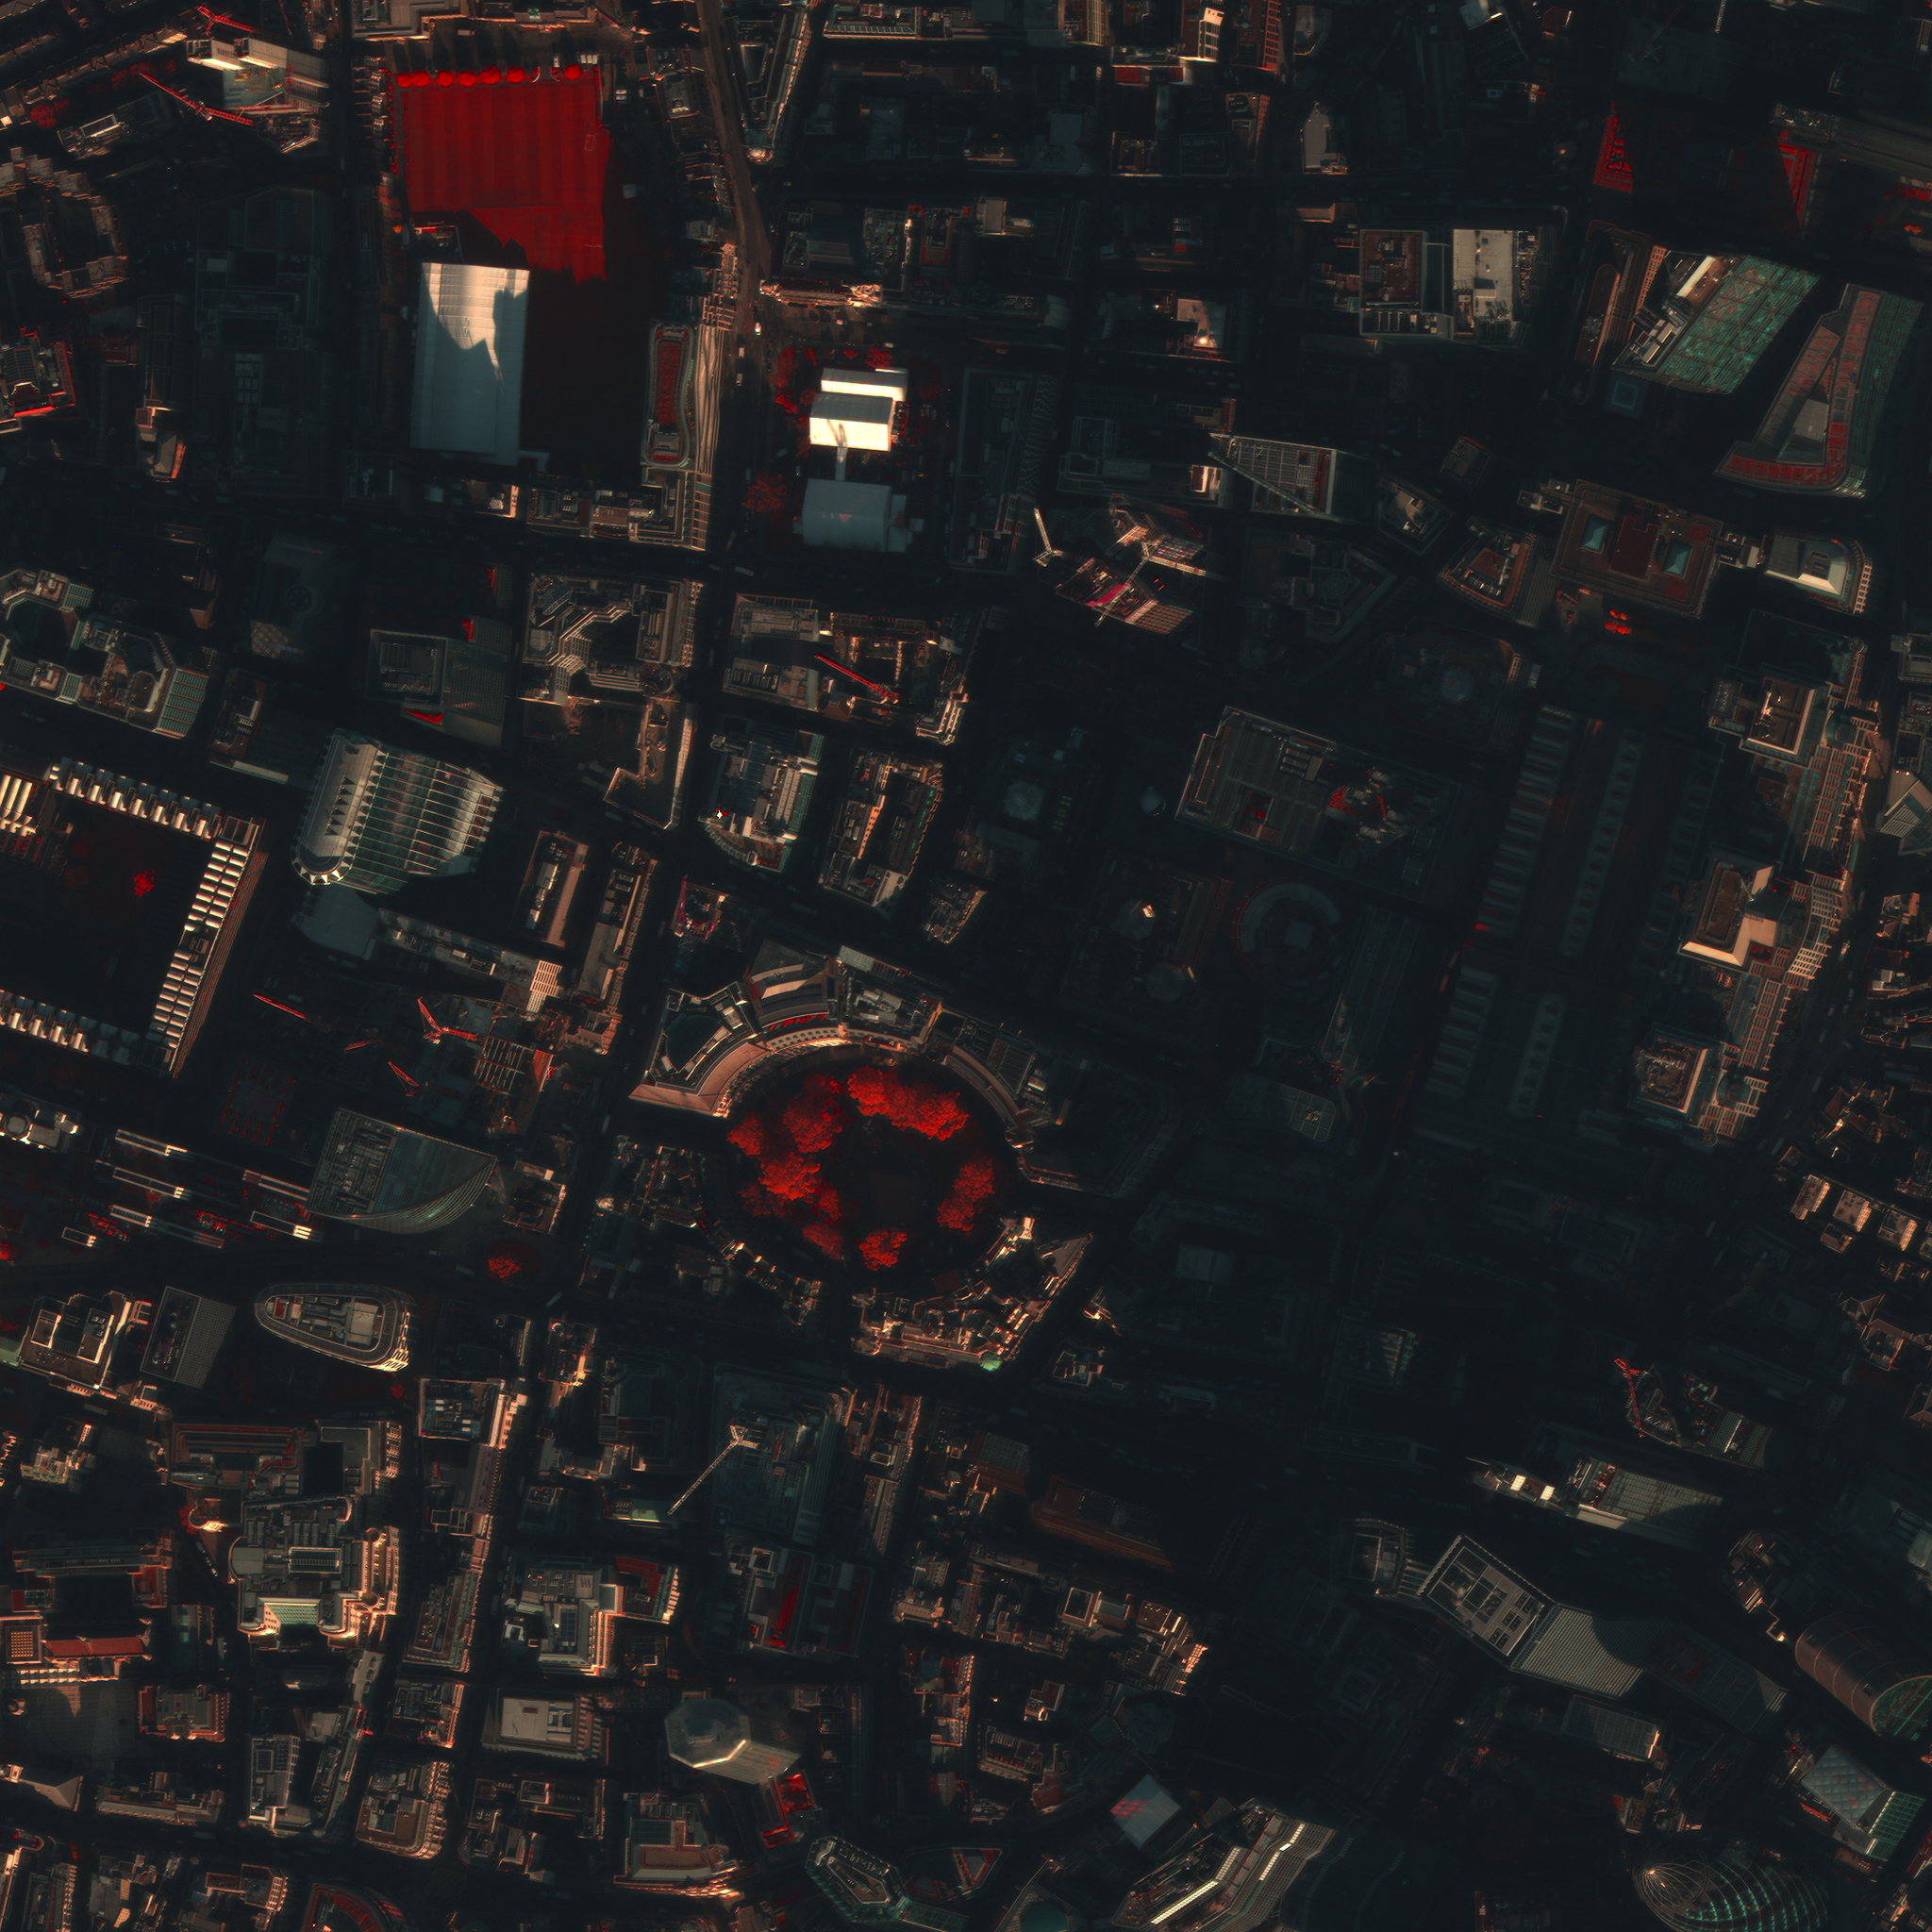

In [6]:
# Specify the path to your TIFF image
image_path = 'results/PCA.tiff'

# Open the TIFF image using PIL
image = Image.open(image_path)

# Display the image in the Jupyter Notebook with a centered title
display(image)
display(HTML("<div style='text-align: center;'><h1>High Resolution Multispectral Image</h1></div>"))


# PSNR

* PSNR < 20 dB: Poor quality, significant loss of information.
* 20 dB < PSNR < 30 dB: Fair quality, moderate loss of information.
* 30 dB < PSNR < 40 dB: Good quality, acceptable for many applications.
* PSNR > 40 dB: Very good to excellent quality.

In [7]:
def psnr(img1, img2, dynamic_range=255):
    """PSNR metric, img uint8 if 225; uint16 if 2047"""
    if not  img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    img1_ = img1.astype(np.float64)
    img2_ = img2.astype(np.float64)
    mse = np.mean((img1_ - img2_)**2)
    if mse <= 1e-10:
        return np.inf
    return 20 * np.log10(dynamic_range / (np.sqrt(mse) + np.finfo(np.float64).eps))

# Load Reference Image

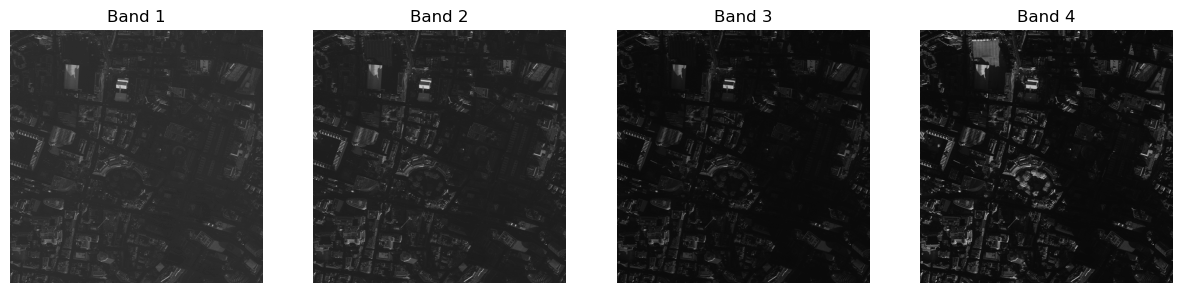

In [8]:
import imageio
import matplotlib.pyplot as plt

# Specify the path to your TIFF image
reference_image_path = 'PAirMax/GE_Lond_Urb/FR/MS.tif'

# Read the TIFF image using imageio.v2
reference_image = imageio.v2.imread(reference_image_path)

# Get the number of bands in the image
num_bands = reference_image.shape[2]

# Display each band separately
fig, axes = plt.subplots(1, num_bands, figsize=(15, 5))

for i in range(num_bands):
    axes[i].imshow(reference_image[:, :, i], cmap='gray')
    axes[i].set_title(f'Band {i + 1}')
    axes[i].axis('off')

plt.show()


In [9]:
# Normalization
max_patch, min_patch = np.max(reference_image, axis=(0,1)), np.min(reference_image, axis=(0,1))
reference_image = np.float32(reference_image-min_patch) / (max_patch - min_patch)
reference_image=np.uint8(reference_image*255)

In [10]:
psnr(fused_img,reference_image)

24.479144985562197